<h1> Bibliotecas e definição de constantes </h1>

In [1]:
#general import
import sys, os
import time

#lib import
import numpy as np
from matplotlib import pyplot as plt
import cv2

#methods import
import test
import mask


[2018-11-03 22:58:11 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-11-03 22:58:11 @__init__.py:80] Saving logging to file: neuralgym_logs/20181103225811633969.


In [2]:
# Nome da imagem a ser carregada (sem extensao)
IMG_NAME = 'img_1'

# Extensao JPG (não alterar)
IMG_EXTENSION = '.jpg'

# Tamanho do rosto
FACE_SIZE = 256

# Diretorios (imagem original, arquivos temp. e restauracao final)
IMG_DIR_PATH = './images/'
INTERM_DIR_PATH = './interm_files/'
INPAINT_DIR_PATH = './inpaints/'

# Verifica e cria os diretorios que nao existem
if not os.path.exists(INTERM_DIR_PATH):
    os.mkdir(INTERM_DIR_PATH)
if not os.path.exists(INPAINT_DIR_PATH):
    os.mkdir(INPAINT_DIR_PATH)

CHECKPOINT_DIR_PATH = './model_logs/release_celeba_256/'

IMG_FILEPATH = IMG_DIR_PATH + IMG_NAME + IMG_EXTENSION

CROP_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_crop' + IMG_EXTENSION
FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face' + IMG_EXTENSION
MASK_FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face_mask' + IMG_EXTENSION
MASK_IMG_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_img_mask' + IMG_EXTENSION

INPAINT_GENERATIVE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_inpaint_generative' + IMG_EXTENSION
INPAINT_OPENCV_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_inpaint_opencv' + IMG_EXTENSION

INPAINT_FINAL_FILEPATH = INPAINT_DIR_PATH + IMG_NAME + '_inpaint' + IMG_EXTENSION

<h1> Validação da imagem de entrada </h1>

Tamanho da imagem carregada: 256 x 256 px
CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 49.5 ms


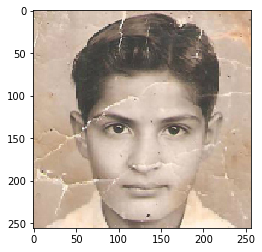

In [3]:
%%time
try:
    image = cv2.cvtColor(cv2.imread(IMG_FILEPATH), cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape
    print('Tamanho da imagem carregada: ' + str(width) + ' x ' + str(height) + ' px')
        
    # Restricao de tamanho minimo 256 x 256 px e formato JPG
    if (height or width) < 256:
        print('A imagem de entrada deve ter pelo menos 256 x 256 px ')
        image = None
        #exit()
    else:
        plt.imshow(image)
except:
    print('Imagem invalida (' + IMG_FILEPATH + '). Verifique se o arquivo existe e se esta no formato .jpg')
    image = None
    #exit()

<h1>Identificação do rosto</h1>

x: 50 y: 77 w: 165 h: 165
CPU times: user 157 ms, sys: 15.9 ms, total: 173 ms
Wall time: 91.1 ms


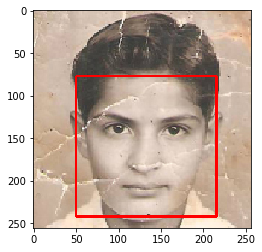

In [4]:
%%time

image_copy = np.copy(image)

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)

for (x,y,w,h) in image_faces:
    cv2.rectangle(image_copy, (x,y), (x+w,y+h), (255,0,0), 2)

plt.imshow(image_copy)
print('x: ' + str(x) + ' y: ' + str(y) + ' w: ' + str(w) + ' h: ' + str(h))

<h1>Corte do rosto</h1>

w:165 h:165 x:50 y:77
CPU times: user 21.3 ms, sys: 43 µs, total: 21.3 ms
Wall time: 20.3 ms


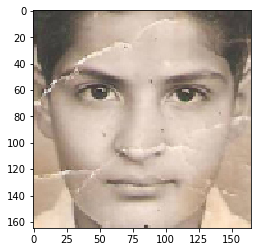

In [5]:
%%time

if len(image_faces) > 1:
    print ('A imagem deve conter apenas um rosto (qtd de rostos identificados: ' + str(len(image_faces)) + ')')
    image = None
    #exit()

else:
    x, y, w, h = image_faces[0]
    print('w:{} h:{} x:{} y:{}'.format(w, h, x, y))
    image_cropped = image[y:y+h, x:x+w]
    cv2.imwrite(CROP_FILEPATH, cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    
    plt.imshow(image_cropped)

<h1> Redimensionamento do rosto </h1>

Redimensionando com INTER_CUBIC


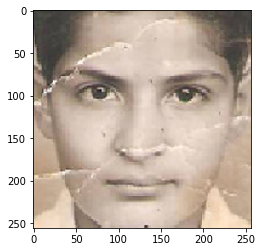

In [6]:
if (w == FACE_SIZE) and (h == FACE_SIZE):
        print('Rosto no tamanho adequado')
        face = image_cropped
    
elif (w < FACE_SIZE) and (h < FACE_SIZE):
    print('Redimensionando com INTER_CUBIC')
    face = cv2.resize(image_cropped, (FACE_SIZE, FACE_SIZE), interpolation = cv2.INTER_CUBIC)

elif (w > FACE_SIZE) and (h > FACE_SIZE):
    print('Redimensionando com INTER_AREA')
    face = cv2.resize(image_cropped, (FACE_SIZE, FACE_SIZE), interpolation = cv2.INTER_AREA)

else:
    print('Não temos um quadrado!')
    #TODO: tratar esse caso
    #exit()

cv2.imwrite(FACE_FILEPATH, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.imshow(face)

<h1>Identificação dos olhos</h1>

CPU times: user 221 ms, sys: 12.2 ms, total: 234 ms
Wall time: 62.3 ms


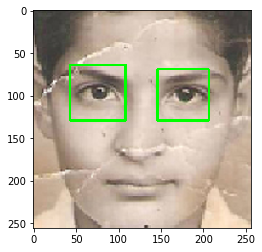

In [7]:
%%time

face_copy = np.copy(face)

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face_eyes = eye_cascade.detectMultiScale(face_gray)

if len(face_eyes) > 2:
    true_eyes = [[0, 0, 0, 0], [0, 0, 0, 0]]
    dim_eyes = [0, 0]
    
    for face_eye in face_eyes:
        curr_eye = int(((face_eye[2])**2 + (face_eye[3])**2)**(0.5))
        
        if curr_eye > max(dim_eyes):
            dim_eyes[dim_eyes.index(min(dim_eyes))] = dim_eyes[dim_eyes.index(max(dim_eyes))]
            dim_eyes[dim_eyes.index(max(dim_eyes))] = curr_eye
            true_eyes[1] = true_eyes[0]
            true_eyes[0] = face_eye
            
        elif curr_eye > min(dim_eyes):
            dim_eyes[dim_eyes.index(min(dim_eyes))] = curr_eye
            true_eyes[1] = face_eye
        else:
            pass
else:
    true_eyes = face_eyes
    

for (ex, ey, ew, eh) in true_eyes:
    cv2.rectangle(face_copy, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

plt.imshow(face_copy)

<h1> Criação da máscara para o rosto (removendo os olhos)</h1>
Máscara em branco (0 = preto, 255 = branco)

x: 43 a 108, y: 64 a 129
x: 146 a 206, y: 69 a 129
CPU times: user 82 ms, sys: 7.86 ms, total: 89.9 ms
Wall time: 29.1 ms


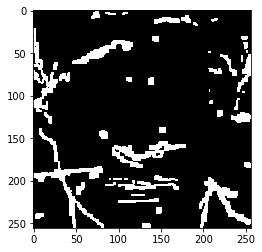

In [8]:
%%time

face_mask = mask.get_mask(face)

# Remove eyes from mask
for (ex, ey, ew, eh) in true_eyes:
    print ('x: ' + str(ex) + ' a ' + str(ex + ew) + ', y: ' + str(ey) + ' a ' + str (ey + eh))
    for m in face_mask[ey:(ey + eh + 1)]:
        m[ex:(ex + ew + 1)] = 0

plt.imshow(face_mask, cmap='gray')

# Save mask
cv2.imwrite(MASK_FACE_FILEPATH, face_mask)

<h1>Inpaint com Deep Generative Model with Contextual Attention</h1>

Shape of image: (256, 256, 3)
Model loaded.
CPU times: user 11.6 s, sys: 550 ms, total: 12.2 s
Wall time: 5.12 s


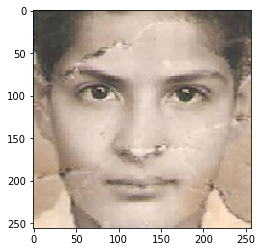

In [9]:
%%time

test.run_inpaint(image = FACE_FILEPATH, 
                 mask = MASK_FACE_FILEPATH, 
                 output = INPAINT_GENERATIVE_FILEPATH, 
                 checkpoint_dir = CHECKPOINT_DIR_PATH)

face_inpaint = cv2.cvtColor(cv2.imread(INPAINT_GENERATIVE_FILEPATH), cv2.COLOR_BGR2RGB)
plt.imshow(face_inpaint)

<h1> Redimensionamento do rosto para o tamanho original </h1>

CPU times: user 22.4 ms, sys: 263 µs, total: 22.7 ms
Wall time: 22.4 ms


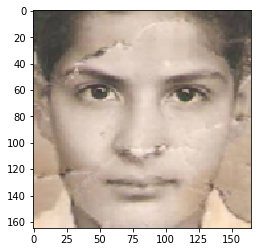

In [10]:
%%time

face_inpaint_redim = cv2.resize(face_inpaint, (w, h), interpolation = cv2.INTER_AREA)
plt.imshow(face_inpaint_redim)

<h1>Inpaint com OpenCV</h1>

CPU times: user 531 ms, sys: 31.4 ms, total: 563 ms
Wall time: 198 ms


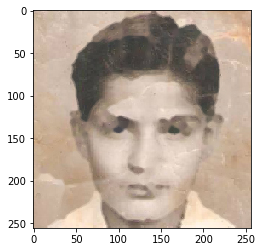

In [11]:
%%time

image_mask = mask.get_mask(image)
image_inpaint = cv2.inpaint(image, image_mask, 3, cv2.INPAINT_TELEA)

plt.imshow(image_inpaint)

# Save full mask
cv2.imwrite(MASK_IMG_FILEPATH, image_mask)

# Save inpaint 
cv2.imwrite(INPAINT_OPENCV_FILEPATH, cv2.cvtColor(image_inpaint, cv2.COLOR_BGR2RGB))

<h1> Merge do rosto com a imagem de fundo, ambos restaurados </h1>

True

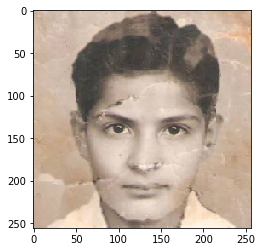

In [12]:
image_final = np.copy(image_inpaint)

for i in range(0, w):
    for j in range(0, h):
        for c in range(0,3):
            image_final[y+j][x+i][c] = face_inpaint_redim[j][i][c]

plt.imshow(image_final)

# Save inpaint 
cv2.imwrite(INPAINT_FINAL_FILEPATH, cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB))